# Sweep: Baseline at All Compression Ratios

Train baseline architecture at 5 compression ratios (4x, 8x, 16x, 32x, 64x)
to generate rate-distortion curves.

**Proven hyperparams:** LR=1e-4, AdamW, ReduceLROnPlateau, batch_size=32

**Monitor with TensorBoard:**
```bash
tensorboard --logdir=runs
```

## 1. Setup

In [1]:
import sys
import gc
import time
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import torch
from tqdm.auto import tqdm

from src.data.datamodule import SARDataModule
from src.models.autoencoder import SARAutoencoder
from src.losses.combined import CombinedLoss
from src.training.trainer import Trainer

print(f"Project root: {project_root}")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Project root: d:\Projects\CNNAutoencoderProject
PyTorch: 2.5.1+cu121
CUDA: True
GPU: NVIDIA GeForce RTX 3070
VRAM: 8.0 GB


## 2. Sweep Configuration

In [2]:
# ============================================================
# SWEEP CONFIGURATION
# ============================================================

# Data
DATA_PATH = "D:/Projects/CNNAutoencoderProject/data/patches/metadata.npy"
BATCH_SIZE = 36
NUM_WORKERS = 4
VAL_FRACTION = 0.1
TRAIN_SUBSET = 0.10  # Use 10% of data

# Fixed training params (proven with baseline@16x -> 20.47 dB)
EPOCHS = 35
LEARNING_RATE = 1e-4
EARLY_STOPPING_PATIENCE = 12
LR_PATIENCE = 10
LR_FACTOR = 0.5
MSE_WEIGHT = 1
SSIM_WEIGHT = 0.1
BASE_CHANNELS = 64

# Sweep variable: latent_channels -> compression ratio
# LC=64 -> 4x, LC=32 -> 8x, LC=21 -> ~12x
SWEEP_LATENT_CHANNELS = [64, 32, 21]

# ============================================================

print("Sweep Plan:")
print(f"  Model: baseline (BC={BASE_CHANNELS})")
print(f"  LR={LEARNING_RATE}, Epochs={EPOCHS}, Patience={EARLY_STOPPING_PATIENCE}")
print(f"  Data: {TRAIN_SUBSET*100:.0f}% subset, batch_size={BATCH_SIZE}")
print()
for lc in SWEEP_LATENT_CHANNELS:
    ratio = (256 * 256) / (16 * 16 * lc)
    name = f"baseline_c{lc}_b{BASE_CHANNELS}_cr{int(ratio)}x"
    print(f"  {name} ({ratio:.0f}x compression)")
print(f"\nTotal runs: {len(SWEEP_LATENT_CHANNELS)}")

Sweep Plan:
  Model: baseline (BC=64)
  LR=0.0001, Epochs=35, Patience=12
  Data: 10% subset, batch_size=36

  baseline_c64_b64_cr4x (4x compression)
  baseline_c32_b64_cr8x (8x compression)
  baseline_c21_b64_cr12x (12x compression)

Total runs: 3


## 3. Load Data (shared across all runs)

In [3]:
import random

print("Loading data...")
dm = SARDataModule(
    patches_path=DATA_PATH,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    val_fraction=VAL_FRACTION,
)

if TRAIN_SUBSET < 1.0:
    full_train_size = len(dm.train_dataset)
    train_subset_size = int(full_train_size * TRAIN_SUBSET)
    train_indices = random.sample(range(full_train_size), train_subset_size)
    dm.train_dataset = torch.utils.data.Subset(dm.train_dataset, train_indices)

    full_val_size = len(dm.val_dataset)
    val_subset_size = int(full_val_size * TRAIN_SUBSET)
    val_indices = random.sample(range(full_val_size), val_subset_size)
    dm.val_dataset = torch.utils.data.Subset(dm.val_dataset, val_indices)

    print(f"Using {TRAIN_SUBSET*100:.0f}% subset:")
    print(f"  Train: {train_subset_size:,} of {full_train_size:,}")
    print(f"  Val: {val_subset_size:,} of {full_val_size:,}")

print(f"\nPreprocessing params: {dm.preprocessing_params}")

Loading data...
Loading metadata from D:\Projects\CNNAutoencoderProject\data\patches\metadata.npy
Total patches: 696277
Train: 626650, Val: 69627
Using 10% subset:
  Train: 62,665 of 626,650
  Val: 6,962 of 69,627

Preprocessing params: {'vmin': np.float32(14.768799), 'vmax': np.float32(24.54073)}


## 4. Run Sweep

Each run trains baseline at one compression ratio. Progress tracked with tqdm, metrics logged to TensorBoard.

In [4]:
results = []

sweep_pbar = tqdm(SWEEP_LATENT_CHANNELS, desc="Sweep Progress", unit="run")

for lc in sweep_pbar:
    ratio = (256 * 256) / (16 * 16 * lc)
    run_name = f"baseline_c{lc}_b{BASE_CHANNELS}_cr{int(ratio)}x"
    sweep_pbar.set_postfix_str(f"{run_name}")

    print(f"\n{'=' * 70}")
    print(f"  {run_name} | LC={lc} | {ratio:.0f}x compression")
    print(f"{'=' * 70}")

    # Create model
    model = SARAutoencoder(
        latent_channels=lc,
        base_channels=BASE_CHANNELS,
    )
    params = model.count_parameters()
    print(f"  Parameters: {params['total']:,}")

    # Loss
    loss_fn = CombinedLoss(mse_weight=MSE_WEIGHT, ssim_weight=SSIM_WEIGHT)

    # Trainer config
    config = {
        'learning_rate': LEARNING_RATE,
        'optimizer': 'adamw',
        'scheduler': 'plateau',
        'lr_patience': LR_PATIENCE,
        'lr_factor': LR_FACTOR,
        'max_grad_norm': 1.0,
        'use_amp': True,
        'notebook': True,
        'run_name': run_name,
        'preprocessing_params': dm.preprocessing_params,
        'model_type': 'baseline',
        'latent_channels': lc,
        'base_channels': BASE_CHANNELS,
        'mse_weight': MSE_WEIGHT,
        'ssim_weight': SSIM_WEIGHT,
        'batch_size': BATCH_SIZE,
        'compression_ratio': ratio,
    }

    train_loader = dm.train_dataloader()
    val_loader = dm.val_dataloader()

    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        loss_fn=loss_fn,
        config=config,
    )

    # Train
    t0 = time.time()
    history = trainer.train(
        epochs=EPOCHS,
        early_stopping_patience=EARLY_STOPPING_PATIENCE,
    )
    elapsed = time.time() - t0

    # Collect results
    result = {
        'run_name': trainer.run_name,
        'latent_channels': lc,
        'compression_ratio': ratio,
        'parameters': params['total'],
        'epochs_trained': len(history),
        'elapsed_min': elapsed / 60,
        'checkpoint': str(trainer.checkpoint_dir / 'best.pth'),
        'log_dir': str(trainer.log_dir),
    }

    if history:
        best_epoch = min(history, key=lambda h: h.get('val_loss', float('inf')))
        result['best_val_loss'] = best_epoch.get('val_loss')
        result['best_psnr'] = best_epoch.get('val_psnr')
        result['best_ssim'] = best_epoch.get('val_ssim')

    results.append(result)

    psnr_str = f"{result.get('best_psnr', 0):.2f} dB" if result.get('best_psnr') else "N/A"
    print(f"\n  Done: {psnr_str} | {elapsed/60:.1f} min | {trainer.checkpoint_dir / 'best.pth'}")

    # Cleanup GPU
    del model, trainer, loss_fn, train_loader, val_loader
    gc.collect()
    torch.cuda.empty_cache()

print("\nSweep complete!")

Sweep Progress:   0%|          | 0/3 [00:00<?, ?run/s]


  baseline_c64_b64_cr4x | LC=64 | 4x compression
  Parameters: 2,872,257
Using device: cuda
GPU memory: 1392MB / 8192MB (17% used, 6.6 GB free)


d:\Projects\CNNAutoencoderProject\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
2026-01-28 18:17:26,768 - Log directory: runs\baseline_c64_b64_cr4x_20260128_181726


Using AdamW optimizer with weight_decay=1e-05
Using ReduceLROnPlateau: patience=10
Mixed Precision (AMP) enabled - ~2x training speedup


2026-01-28 18:17:26,768 - Checkpoint directory: checkpoints\baseline_c64_b64_cr4x_20260128_181726
2026-01-28 18:17:26,769 - Mixed Precision (AMP): enabled
2026-01-28 18:17:26,769 - Starting training for 35 epochs
2026-01-28 18:17:26,770 - Model: SARAutoencoder
2026-01-28 18:17:26,770 - Config: {'learning_rate': 0.0001, 'optimizer': 'adamw', 'scheduler': 'plateau', 'lr_patience': 10, 'lr_factor': 0.5, 'max_grad_norm': 1.0, 'use_amp': True, 'notebook': True, 'run_name': 'baseline_c64_b64_cr4x', 'preprocessing_params': {'vmin': np.float32(14.768799), 'vmax': np.float32(24.54073)}, 'model_type': 'baseline', 'latent_channels': 64, 'base_channels': 64, 'mse_weight': 1, 'ssim_weight': 0.1, 'batch_size': 36, 'compression_ratio': 4.0}


Epoch 1 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 18:20:01,132 - New best model saved (val_loss: 0.0392) + archived to best_20260128_182001_epoch000_loss0.0392.pth
2026-01-28 18:20:01,274 - Epoch 1/35 | Train: loss=0.0488, psnr=20.21, ssim=0.6121 | Val: loss=0.0392, psnr=20.21, ssim=0.7033 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 2 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 18:21:50,699 - New best model saved (val_loss: 0.0298) + archived to best_20260128_182150_epoch001_loss0.0298.pth
2026-01-28 18:21:50,888 - Epoch 2/35 | Train: loss=0.0342, psnr=21.50, ssim=0.7296 | Val: loss=0.0298, psnr=22.62, ssim=0.7565 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 3 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 18:23:41,415 - New best model saved (val_loss: 0.0274) + archived to best_20260128_182341_epoch002_loss0.0274.pth
2026-01-28 18:23:41,534 - Epoch 3/35 | Train: loss=0.0308, psnr=21.94, ssim=0.7570 | Val: loss=0.0274, psnr=23.00, ssim=0.7763 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 4 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 18:25:31,348 - New best model saved (val_loss: 0.0261) + archived to best_20260128_182531_epoch003_loss0.0261.pth
2026-01-28 18:25:31,441 - Epoch 4/35 | Train: loss=0.0284, psnr=22.27, ssim=0.7763 | Val: loss=0.0261, psnr=23.20, ssim=0.7865 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 5 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 18:27:21,472 - New best model saved (val_loss: 0.0243) + archived to best_20260128_182721_epoch004_loss0.0243.pth
2026-01-28 18:27:21,561 - Epoch 5/35 | Train: loss=0.0264, psnr=22.57, ssim=0.7924 | Val: loss=0.0243, psnr=23.18, ssim=0.8055 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 6 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 18:29:11,998 - New best model saved (val_loss: 0.0235) + archived to best_20260128_182911_epoch005_loss0.0235.pth
2026-01-28 18:29:12,101 - Epoch 6/35 | Train: loss=0.0256, psnr=22.65, ssim=0.7992 | Val: loss=0.0235, psnr=23.67, ssim=0.8083 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 7 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 18:31:02,559 - New best model saved (val_loss: 0.0228) + archived to best_20260128_183102_epoch006_loss0.0228.pth
2026-01-28 18:31:02,652 - Epoch 7/35 | Train: loss=0.0256, psnr=22.61, ssim=0.7998 | Val: loss=0.0228, psnr=23.64, ssim=0.8155 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 8 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 8 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 18:32:53,508 - New best model saved (val_loss: 0.0221) + archived to best_20260128_183253_epoch007_loss0.0221.pth
2026-01-28 18:32:53,596 - Epoch 8/35 | Train: loss=0.0239, psnr=22.93, ssim=0.8127 | Val: loss=0.0221, psnr=23.86, ssim=0.8202 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 9 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 9 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 18:34:45,099 - Epoch 9/35 | Train: loss=0.0234, psnr=23.04, ssim=0.8166 | Val: loss=0.0248, psnr=22.27, ssim=0.8112 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 10 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 18:36:34,583 - New best model saved (val_loss: 0.0216) + archived to best_20260128_183634_epoch009_loss0.0216.pth
2026-01-28 18:36:34,687 - Epoch 10/35 | Train: loss=0.0223, psnr=23.25, ssim=0.8253 | Val: loss=0.0216, psnr=23.81, ssim=0.8258 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 11 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 11 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 18:38:25,161 - New best model saved (val_loss: 0.0201) + archived to best_20260128_183825_epoch010_loss0.0201.pth
2026-01-28 18:38:25,251 - Epoch 11/35 | Train: loss=0.0223, psnr=23.23, ssim=0.8252 | Val: loss=0.0201, psnr=24.36, ssim=0.8357 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 12 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 12 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 18:40:13,894 - Epoch 12/35 | Train: loss=0.0217, psnr=23.36, ssim=0.8295 | Val: loss=0.0218, psnr=23.59, ssim=0.8258 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 13 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 13 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 18:42:03,659 - New best model saved (val_loss: 0.0198) + archived to best_20260128_184203_epoch012_loss0.0198.pth
2026-01-28 18:42:03,759 - Epoch 13/35 | Train: loss=0.0220, psnr=23.32, ssim=0.8278 | Val: loss=0.0198, psnr=24.16, ssim=0.8400 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 14 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 14 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 18:43:53,759 - Epoch 14/35 | Train: loss=0.0216, psnr=23.41, ssim=0.8306 | Val: loss=0.0203, psnr=23.74, ssim=0.8392 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 15 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 15 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 18:45:40,182 - Epoch 15/35 | Train: loss=0.0214, psnr=23.46, ssim=0.8314 | Val: loss=0.0212, psnr=23.78, ssim=0.8300 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 16 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 16 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 18:47:29,485 - Epoch 16/35 | Train: loss=0.0213, psnr=23.47, ssim=0.8322 | Val: loss=0.0199, psnr=24.30, ssim=0.8377 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 17 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 17 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 18:49:19,987 - New best model saved (val_loss: 0.0197) + archived to best_20260128_184919_epoch016_loss0.0197.pth
2026-01-28 18:49:20,074 - Epoch 17/35 | Train: loss=0.0211, psnr=23.56, ssim=0.8338 | Val: loss=0.0197, psnr=24.21, ssim=0.8410 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 18 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 18 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 18:51:09,761 - Epoch 18/35 | Train: loss=0.0206, psnr=23.68, ssim=0.8374 | Val: loss=0.0260, psnr=21.28, ssim=0.8147 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 19 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 19 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 18:53:00,766 - Epoch 19/35 | Train: loss=0.0206, psnr=23.71, ssim=0.8370 | Val: loss=0.0202, psnr=24.09, ssim=0.8365 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 20 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 20 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 18:54:51,361 - New best model saved (val_loss: 0.0194) + archived to best_20260128_185451_epoch019_loss0.0194.pth
2026-01-28 18:54:51,449 - Epoch 20/35 | Train: loss=0.0203, psnr=23.81, ssim=0.8390 | Val: loss=0.0194, psnr=23.80, ssim=0.8476 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 21 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 21 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 18:56:43,923 - New best model saved (val_loss: 0.0187) + archived to best_20260128_185643_epoch020_loss0.0187.pth
2026-01-28 18:56:44,022 - Epoch 21/35 | Train: loss=0.0203, psnr=23.84, ssim=0.8388 | Val: loss=0.0187, psnr=24.59, ssim=0.8478 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 22 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 22 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 18:58:32,395 - Epoch 22/35 | Train: loss=0.0197, psnr=24.02, ssim=0.8427 | Val: loss=0.0198, psnr=23.62, ssim=0.8457 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 23 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 23 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:00:21,801 - Epoch 23/35 | Train: loss=0.0205, psnr=23.81, ssim=0.8375 | Val: loss=0.0195, psnr=24.15, ssim=0.8434 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 24 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 24 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:02:12,099 - Epoch 24/35 | Train: loss=0.0195, psnr=24.11, ssim=0.8441 | Val: loss=0.0218, psnr=22.60, ssim=0.8372 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 25 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 25 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:04:01,296 - Epoch 25/35 | Train: loss=0.0194, psnr=24.14, ssim=0.8443 | Val: loss=0.0193, psnr=24.17, ssim=0.8453 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 26 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 26 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:05:51,203 - New best model saved (val_loss: 0.0185) + archived to best_20260128_190551_epoch025_loss0.0185.pth
2026-01-28 19:05:51,297 - Epoch 26/35 | Train: loss=0.0199, psnr=24.02, ssim=0.8412 | Val: loss=0.0185, psnr=24.75, ssim=0.8485 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 27 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 27 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:07:42,745 - Epoch 27/35 | Train: loss=0.0198, psnr=24.05, ssim=0.8415 | Val: loss=0.0185, psnr=24.77, ssim=0.8483 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 28 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 28 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:09:32,861 - New best model saved (val_loss: 0.0185) + archived to best_20260128_190932_epoch027_loss0.0185.pth
2026-01-28 19:09:32,948 - Epoch 28/35 | Train: loss=0.0194, psnr=24.19, ssim=0.8447 | Val: loss=0.0185, psnr=24.66, ssim=0.8495 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 29 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 29 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:11:23,760 - Epoch 29/35 | Train: loss=0.0195, psnr=24.12, ssim=0.8438 | Val: loss=0.0185, psnr=24.38, ssim=0.8515 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 30 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 30 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:13:11,451 - New best model saved (val_loss: 0.0182) + archived to best_20260128_191311_epoch029_loss0.0182.pth
2026-01-28 19:13:11,537 - Epoch 30/35 | Train: loss=0.0196, psnr=24.13, ssim=0.8430 | Val: loss=0.0182, psnr=24.83, ssim=0.8509 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 31 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 31 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:14:58,421 - New best model saved (val_loss: 0.0181) + archived to best_20260128_191458_epoch030_loss0.0181.pth
2026-01-28 19:14:58,516 - Epoch 31/35 | Train: loss=0.0195, psnr=24.17, ssim=0.8437 | Val: loss=0.0181, psnr=24.82, ssim=0.8516 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 32 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 32 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:16:45,941 - Epoch 32/35 | Train: loss=0.0194, psnr=24.19, ssim=0.8441 | Val: loss=0.0186, psnr=24.70, ssim=0.8477 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 33 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 33 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:18:33,605 - Epoch 33/35 | Train: loss=0.0192, psnr=24.24, ssim=0.8456 | Val: loss=0.0184, psnr=24.77, ssim=0.8495 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 34 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 34 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:20:21,090 - New best model saved (val_loss: 0.0181) + archived to best_20260128_192021_epoch033_loss0.0181.pth
2026-01-28 19:20:21,174 - Epoch 34/35 | Train: loss=0.0191, psnr=24.29, ssim=0.8462 | Val: loss=0.0181, psnr=24.78, ssim=0.8520 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 35 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 35 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:22:14,110 - New best model saved (val_loss: 0.0181) + archived to best_20260128_192214_epoch034_loss0.0181.pth
2026-01-28 19:22:14,207 - Epoch 35/35 | Train: loss=0.0192, psnr=24.26, ssim=0.8456 | Val: loss=0.0181, psnr=24.79, ssim=0.8521 | LR: 1.00e-04 | GPU: 0.04GB
2026-01-28 19:22:14,208 - Training complete. Best val loss: 0.0181



  Done: 24.79 dB | 64.8 min | checkpoints\baseline_c64_b64_cr4x_20260128_181726\best.pth


2026-01-28 19:22:21,022 - Log directory: runs\baseline_c32_b64_cr8x_20260128_192221
2026-01-28 19:22:21,024 - Checkpoint directory: checkpoints\baseline_c32_b64_cr8x_20260128_192221
2026-01-28 19:22:21,025 - Mixed Precision (AMP): enabled
2026-01-28 19:22:21,025 - Starting training for 35 epochs
2026-01-28 19:22:21,026 - Model: SARAutoencoder
2026-01-28 19:22:21,027 - Config: {'learning_rate': 0.0001, 'optimizer': 'adamw', 'scheduler': 'plateau', 'lr_patience': 10, 'lr_factor': 0.5, 'max_grad_norm': 1.0, 'use_amp': True, 'notebook': True, 'run_name': 'baseline_c32_b64_cr8x', 'preprocessing_params': {'vmin': np.float32(14.768799), 'vmax': np.float32(24.54073)}, 'model_type': 'baseline', 'latent_channels': 32, 'base_channels': 64, 'mse_weight': 1, 'ssim_weight': 0.1, 'batch_size': 36, 'compression_ratio': 8.0}



  baseline_c32_b64_cr8x | LC=32 | 8x compression
  Parameters: 2,462,625
Using device: cuda
GPU memory: 1574MB / 8192MB (19% used, 6.5 GB free)
Using AdamW optimizer with weight_decay=1e-05
Using ReduceLROnPlateau: patience=10
Mixed Precision (AMP) enabled - ~2x training speedup


Epoch 1 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:25:00,667 - New best model saved (val_loss: 0.0482) + archived to best_20260128_192500_epoch000_loss0.0482.pth
2026-01-28 19:25:00,820 - Epoch 1/35 | Train: loss=0.0571, psnr=19.61, ssim=0.5421 | Val: loss=0.0482, psnr=20.91, ssim=0.5986 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 2 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:26:52,303 - New best model saved (val_loss: 0.0456) + archived to best_20260128_192652_epoch001_loss0.0456.pth
2026-01-28 19:26:52,409 - Epoch 2/35 | Train: loss=0.0477, psnr=20.32, ssim=0.6168 | Val: loss=0.0456, psnr=21.13, ssim=0.6214 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 3 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:28:41,071 - New best model saved (val_loss: 0.0446) + archived to best_20260128_192841_epoch002_loss0.0446.pth
2026-01-28 19:28:41,172 - Epoch 3/35 | Train: loss=0.0457, psnr=20.54, ssim=0.6315 | Val: loss=0.0446, psnr=21.21, ssim=0.6298 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 4 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:30:27,133 - New best model saved (val_loss: 0.0435) + archived to best_20260128_193027_epoch003_loss0.0435.pth
2026-01-28 19:30:27,223 - Epoch 4/35 | Train: loss=0.0451, psnr=20.61, ssim=0.6361 | Val: loss=0.0435, psnr=20.98, ssim=0.6449 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 5 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:32:14,334 - New best model saved (val_loss: 0.0431) + archived to best_20260128_193214_epoch004_loss0.0431.pth
2026-01-28 19:32:14,427 - Epoch 5/35 | Train: loss=0.0443, psnr=20.73, ssim=0.6424 | Val: loss=0.0431, psnr=21.35, ssim=0.6428 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 6 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:34:01,903 - Epoch 6/35 | Train: loss=0.0437, psnr=20.80, ssim=0.6462 | Val: loss=0.0451, psnr=20.74, ssim=0.6334 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 7 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:35:48,847 - New best model saved (val_loss: 0.0421) + archived to best_20260128_193548_epoch006_loss0.0421.pth
2026-01-28 19:35:48,936 - Epoch 7/35 | Train: loss=0.0435, psnr=20.86, ssim=0.6480 | Val: loss=0.0421, psnr=21.56, ssim=0.6492 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 8 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 8 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:37:34,497 - Epoch 8/35 | Train: loss=0.0433, psnr=20.85, ssim=0.6495 | Val: loss=0.0425, psnr=21.28, ssim=0.6499 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 9 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 9 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:39:20,599 - Epoch 9/35 | Train: loss=0.0432, psnr=20.87, ssim=0.6500 | Val: loss=0.0423, psnr=21.52, ssim=0.6476 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 10 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:41:06,390 - New best model saved (val_loss: 0.0415) + archived to best_20260128_194106_epoch009_loss0.0415.pth
2026-01-28 19:41:06,486 - Epoch 10/35 | Train: loss=0.0430, psnr=20.92, ssim=0.6518 | Val: loss=0.0415, psnr=21.58, ssim=0.6541 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 11 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 11 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:42:52,903 - Epoch 11/35 | Train: loss=0.0426, psnr=20.96, ssim=0.6549 | Val: loss=0.0419, psnr=21.56, ssim=0.6505 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 12 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 12 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:44:39,231 - Epoch 12/35 | Train: loss=0.0427, psnr=20.96, ssim=0.6532 | Val: loss=0.0416, psnr=21.60, ssim=0.6534 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 13 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 13 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:46:24,299 - Epoch 13/35 | Train: loss=0.0427, psnr=20.97, ssim=0.6533 | Val: loss=0.0423, psnr=21.42, ssim=0.6492 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 14 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 14 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:48:10,431 - Epoch 14/35 | Train: loss=0.0426, psnr=20.99, ssim=0.6545 | Val: loss=0.0426, psnr=21.39, ssim=0.6466 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 15 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 15 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:49:55,703 - New best model saved (val_loss: 0.0414) + archived to best_20260128_194955_epoch014_loss0.0414.pth
2026-01-28 19:49:55,794 - Epoch 15/35 | Train: loss=0.0420, psnr=21.10, ssim=0.6581 | Val: loss=0.0414, psnr=21.54, ssim=0.6558 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 16 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 16 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:51:42,193 - New best model saved (val_loss: 0.0414) + archived to best_20260128_195142_epoch015_loss0.0414.pth
2026-01-28 19:51:42,299 - Epoch 16/35 | Train: loss=0.0420, psnr=21.10, ssim=0.6578 | Val: loss=0.0414, psnr=21.41, ssim=0.6586 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 17 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 17 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:53:29,030 - New best model saved (val_loss: 0.0413) + archived to best_20260128_195328_epoch016_loss0.0413.pth
2026-01-28 19:53:29,131 - Epoch 17/35 | Train: loss=0.0421, psnr=21.11, ssim=0.6568 | Val: loss=0.0413, psnr=21.47, ssim=0.6584 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 18 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 18 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:55:15,413 - New best model saved (val_loss: 0.0410) + archived to best_20260128_195515_epoch017_loss0.0410.pth
2026-01-28 19:55:15,509 - Epoch 18/35 | Train: loss=0.0418, psnr=21.16, ssim=0.6591 | Val: loss=0.0410, psnr=21.70, ssim=0.6578 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 19 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 19 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:57:01,566 - New best model saved (val_loss: 0.0409) + archived to best_20260128_195701_epoch018_loss0.0409.pth
2026-01-28 19:57:01,664 - Epoch 19/35 | Train: loss=0.0415, psnr=21.20, ssim=0.6606 | Val: loss=0.0409, psnr=21.67, ssim=0.6596 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 20 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 20 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 19:58:47,780 - Epoch 20/35 | Train: loss=0.0415, psnr=21.20, ssim=0.6608 | Val: loss=0.0410, psnr=21.60, ssim=0.6596 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 21 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 21 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 20:00:34,913 - Epoch 21/35 | Train: loss=0.0414, psnr=21.24, ssim=0.6609 | Val: loss=0.0411, psnr=21.40, ssim=0.6610 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 22 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 22 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 20:02:22,972 - Epoch 22/35 | Train: loss=0.0415, psnr=21.23, ssim=0.6604 | Val: loss=0.0411, psnr=21.54, ssim=0.6593 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 23 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 23 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 20:04:11,263 - Epoch 23/35 | Train: loss=0.0413, psnr=21.27, ssim=0.6617 | Val: loss=0.0458, psnr=20.02, ssim=0.6412 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 24 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 24 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 20:05:57,728 - Epoch 24/35 | Train: loss=0.0413, psnr=21.26, ssim=0.6615 | Val: loss=0.0431, psnr=21.09, ssim=0.6468 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 25 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 25 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 20:07:44,374 - Epoch 25/35 | Train: loss=0.0411, psnr=21.30, ssim=0.6627 | Val: loss=0.0411, psnr=21.64, ssim=0.6577 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 26 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 26 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 20:09:32,155 - Epoch 26/35 | Train: loss=0.0412, psnr=21.30, ssim=0.6622 | Val: loss=0.0414, psnr=21.48, ssim=0.6576 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 27 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 27 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 20:11:18,117 - New best model saved (val_loss: 0.0405) + archived to best_20260128_201118_epoch026_loss0.0405.pth
2026-01-28 20:11:18,204 - Epoch 27/35 | Train: loss=0.0410, psnr=21.34, ssim=0.6636 | Val: loss=0.0405, psnr=21.77, ssim=0.6614 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 28 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 28 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 20:13:04,414 - Epoch 28/35 | Train: loss=0.0410, psnr=21.36, ssim=0.6635 | Val: loss=0.0408, psnr=21.56, ssim=0.6617 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 29 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 29 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 20:14:50,696 - Epoch 29/35 | Train: loss=0.0409, psnr=21.35, ssim=0.6639 | Val: loss=0.0408, psnr=21.62, ssim=0.6614 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 30 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 30 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 20:16:37,148 - Epoch 30/35 | Train: loss=0.0410, psnr=21.35, ssim=0.6638 | Val: loss=0.0427, psnr=21.08, ssim=0.6511 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 31 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 31 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 20:18:20,686 - New best model saved (val_loss: 0.0404) + archived to best_20260128_201820_epoch030_loss0.0404.pth
2026-01-28 20:18:20,770 - Epoch 31/35 | Train: loss=0.0408, psnr=21.37, ssim=0.6647 | Val: loss=0.0404, psnr=21.75, ssim=0.6628 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 32 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 32 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 20:20:07,401 - Epoch 32/35 | Train: loss=0.0406, psnr=21.41, ssim=0.6663 | Val: loss=0.0405, psnr=21.72, ssim=0.6629 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 33 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 33 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 20:21:54,079 - Epoch 33/35 | Train: loss=0.0408, psnr=21.39, ssim=0.6652 | Val: loss=0.0405, psnr=21.71, ssim=0.6627 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 34 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 34 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 20:23:40,404 - Epoch 34/35 | Train: loss=0.0406, psnr=21.40, ssim=0.6663 | Val: loss=0.0411, psnr=21.67, ssim=0.6568 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 35 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 35 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 20:25:26,885 - Epoch 35/35 | Train: loss=0.0407, psnr=21.39, ssim=0.6656 | Val: loss=0.0404, psnr=21.78, ssim=0.6620 | LR: 1.00e-04 | GPU: 0.04GB
2026-01-28 20:25:26,886 - Training complete. Best val loss: 0.0404



  Done: 21.75 dB | 63.1 min | checkpoints\baseline_c32_b64_cr8x_20260128_192221\best.pth


2026-01-28 20:25:32,497 - Log directory: runs\baseline_c21_b64_cr12x_20260128_202532
2026-01-28 20:25:32,497 - Checkpoint directory: checkpoints\baseline_c21_b64_cr12x_20260128_202532
2026-01-28 20:25:32,498 - Mixed Precision (AMP): enabled
2026-01-28 20:25:32,498 - Starting training for 35 epochs
2026-01-28 20:25:32,499 - Model: SARAutoencoder
2026-01-28 20:25:32,500 - Config: {'learning_rate': 0.0001, 'optimizer': 'adamw', 'scheduler': 'plateau', 'lr_patience': 10, 'lr_factor': 0.5, 'max_grad_norm': 1.0, 'use_amp': True, 'notebook': True, 'run_name': 'baseline_c21_b64_cr12x', 'preprocessing_params': {'vmin': np.float32(14.768799), 'vmax': np.float32(24.54073)}, 'model_type': 'baseline', 'latent_channels': 21, 'base_channels': 64, 'mse_weight': 1, 'ssim_weight': 0.1, 'batch_size': 36, 'compression_ratio': 12.19047619047619}



  baseline_c21_b64_cr12x | LC=21 | 12x compression
  Parameters: 2,321,814
Using device: cuda
GPU memory: 1578MB / 8192MB (19% used, 6.5 GB free)
Using AdamW optimizer with weight_decay=1e-05
Using ReduceLROnPlateau: patience=10
Mixed Precision (AMP) enabled - ~2x training speedup


Epoch 1 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 20:28:02,393 - New best model saved (val_loss: 0.0589) + archived to best_20260128_202802_epoch000_loss0.0589.pth
2026-01-28 20:28:02,559 - Epoch 1/35 | Train: loss=0.0658, psnr=19.08, ssim=0.4681 | Val: loss=0.0589, psnr=20.03, ssim=0.5106 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 2 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 20:29:48,062 - New best model saved (val_loss: 0.0575) + archived to best_20260128_202948_epoch001_loss0.0575.pth
2026-01-28 20:29:48,149 - Epoch 2/35 | Train: loss=0.0589, psnr=19.65, ssim=0.5194 | Val: loss=0.0575, psnr=20.14, ssim=0.5220 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 3 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 20:31:34,953 - New best model saved (val_loss: 0.0570) + archived to best_20260128_203134_epoch002_loss0.0570.pth
2026-01-28 20:31:35,048 - Epoch 3/35 | Train: loss=0.0578, psnr=19.78, ssim=0.5278 | Val: loss=0.0570, psnr=20.35, ssim=0.5224 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 4 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 20:33:21,898 - New best model saved (val_loss: 0.0562) + archived to best_20260128_203321_epoch003_loss0.0562.pth
2026-01-28 20:33:21,994 - Epoch 4/35 | Train: loss=0.0570, psnr=19.87, ssim=0.5331 | Val: loss=0.0562, psnr=20.36, ssim=0.5297 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 5 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 20:35:08,229 - New best model saved (val_loss: 0.0561) + archived to best_20260128_203508_epoch004_loss0.0561.pth
2026-01-28 20:35:08,340 - Epoch 5/35 | Train: loss=0.0566, psnr=19.93, ssim=0.5361 | Val: loss=0.0561, psnr=20.38, ssim=0.5310 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 6 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 20:36:55,496 - Epoch 6/35 | Train: loss=0.0561, psnr=19.98, ssim=0.5395 | Val: loss=0.0569, psnr=20.31, ssim=0.5245 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 7 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-28 20:38:42,425 - New best model saved (val_loss: 0.0559) + archived to best_20260128_203842_epoch006_loss0.0559.pth
2026-01-28 20:38:42,542 - Epoch 7/35 | Train: loss=0.0561, psnr=19.98, ssim=0.5395 | Val: loss=0.0559, psnr=20.34, ssim=0.5339 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 8 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 5. Load Results from Checkpoints

If kernel restarted or sweep was interrupted, load results from saved checkpoints.

In [8]:
import glob
import torch
from pathlib import Path

def load_results_from_checkpoints(min_epochs=30):
    """Load results from all baseline checkpoint directories.
    
    Args:
        min_epochs: Only include checkpoints with at least this many epochs trained.
                   Set to 0 to include all. Helps filter out incomplete runs.
    """
    checkpoint_dir = Path('checkpoints')
    results = []
    
    # Find all baseline checkpoint directories
    pattern = str(checkpoint_dir / 'baseline_c*_b*_cr*x_*')
    checkpoint_dirs = sorted(glob.glob(pattern))
    
    print(f"Found {len(checkpoint_dirs)} baseline checkpoint directories")
    
    for ckpt_dir in checkpoint_dirs:
        ckpt_path = Path(ckpt_dir) / 'best.pth'
        if not ckpt_path.exists():
            continue  # Skip dirs without best.pth
        
        try:
            checkpoint = torch.load(ckpt_path, map_location='cpu', weights_only=False)
            config = checkpoint.get('config', {})
            history = checkpoint.get('history', [])
            epochs_trained = len(history)
            
            # Filter out incomplete runs
            if epochs_trained < min_epochs:
                print(f"  SKIP: {Path(ckpt_dir).name} (only {epochs_trained} epochs, need {min_epochs}+)")
                continue
            
            # Extract best metrics from history
            if history:
                best_epoch = min(history, key=lambda h: h.get('val_loss', float('inf')))
                best_psnr = best_epoch.get('val_psnr', 0)
                best_ssim = best_epoch.get('val_ssim', 0)
                best_loss = best_epoch.get('val_loss', float('inf'))
            else:
                best_psnr = best_ssim = best_loss = None
            
            result = {
                'run_name': Path(ckpt_dir).name,
                'latent_channels': config.get('latent_channels'),
                'compression_ratio': config.get('compression_ratio'),
                'base_channels': config.get('base_channels'),
                'parameters': None,
                'epochs_trained': epochs_trained,
                'checkpoint': str(ckpt_path),
                'best_val_loss': best_loss,
                'best_psnr': best_psnr,
                'best_ssim': best_ssim,
            }
            results.append(result)
            
        except Exception as e:
            print(f"  ERROR loading {ckpt_dir}: {e}")
    
    # Keep best per compression ratio (most epochs trained, then lowest val_loss as tiebreaker)
    best_by_ratio = {}
    for r in results:
        ratio = r['compression_ratio']
        if ratio not in best_by_ratio:
            best_by_ratio[ratio] = r
        else:
            # Prefer more epochs, then lower val_loss
            existing = best_by_ratio[ratio]
            if (r['epochs_trained'] > existing['epochs_trained'] or 
                (r['epochs_trained'] == existing['epochs_trained'] and 
                 r['best_val_loss'] < existing['best_val_loss'])):
                best_by_ratio[ratio] = r
    
    results = list(best_by_ratio.values())
    
    # Sort by compression ratio for display
    results.sort(key=lambda r: r['compression_ratio'] if r['compression_ratio'] else 999)
    
    print(f"\nUsing {len(results)} checkpoints (best completed run per ratio):")
    for r in results:
        print(f"  {r['run_name']}: {r['compression_ratio']:.0f}x, {r['epochs_trained']} epochs, PSNR={r['best_psnr']:.2f} dB, SSIM={r['best_ssim']:.4f}")
    
    return results

# Load results from checkpoints (min_epochs=30 filters out incomplete runs)
results = load_results_from_checkpoints(min_epochs=5)

Found 15 baseline checkpoint directories
  SKIP: baseline_c16_b64_cr16x_20260127_230920 (only 2 epochs, need 5+)

Using 4 checkpoints (best completed run per ratio):
  baseline_c64_b64_cr4x_20260128_181726: 4x, 34 epochs, PSNR=24.78 dB, SSIM=0.8520
  baseline_c32_b64_cr8x_20260127_205741: 8x, 34 epochs, PSNR=21.29 dB, SSIM=0.6737
  baseline_c21_b64_cr12x_20260127_220001: 12x, 34 epochs, PSNR=19.81 dB, SSIM=0.5853
  baseline_c16_b64_cr16x_20260127_231730: 16x, 34 epochs, PSNR=19.43 dB, SSIM=0.5676


In [9]:
print(f"{'Run':<40} {'Ratio':>6} {'PSNR':>10} {'SSIM':>10} {'Epochs':>8}")
print("-" * 78)

for r in results:
    name = r['run_name']
    ratio = f"{r['compression_ratio']:.0f}x"
    psnr = f"{r['best_psnr']:.2f} dB" if r.get('best_psnr') else "N/A"
    ssim = f"{r['best_ssim']:.4f}" if r.get('best_ssim') else "N/A"
    epochs = str(r.get('epochs_trained', 'N/A'))
    print(f"{name:<40} {ratio:>6} {psnr:>10} {ssim:>10} {epochs:>8}")

Run                                       Ratio       PSNR       SSIM   Epochs
------------------------------------------------------------------------------
baseline_c64_b64_cr4x_20260128_181726        4x   24.78 dB     0.8520       34
baseline_c32_b64_cr8x_20260127_205741        8x   21.29 dB     0.6737       34
baseline_c21_b64_cr12x_20260127_220001      12x   19.81 dB     0.5853       34
baseline_c16_b64_cr16x_20260127_231730      16x   19.43 dB     0.5676       34


## 6. Rate-Distortion Curve

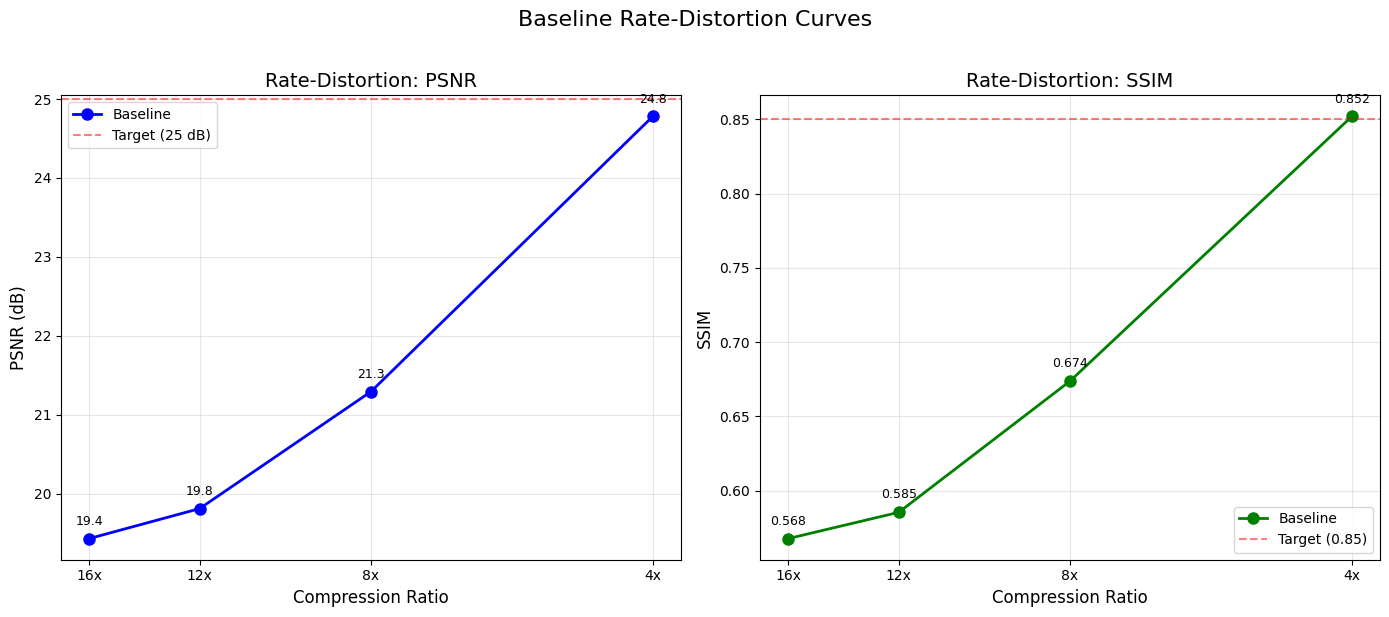

Saved to: runs/baseline_rate_distortion_20260128.png


In [10]:
import matplotlib.pyplot as plt
from datetime import datetime

# Extract data for plotting
ratios = [r['compression_ratio'] for r in results if r.get('best_psnr')]
psnrs = [r['best_psnr'] for r in results if r.get('best_psnr')]
ssims = [r['best_ssim'] for r in results if r.get('best_ssim')]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# PSNR vs Compression Ratio
ax1.plot(ratios, psnrs, 'bo-', markersize=8, linewidth=2, label='Baseline')
for r, p in zip(ratios, psnrs):
    ax1.annotate(f'{p:.1f}', (r, p), textcoords='offset points',
                 xytext=(0, 10), ha='center', fontsize=9)
ax1.axhline(y=25, color='r', linestyle='--', alpha=0.5, label='Target (25 dB)')
ax1.set_xlabel('Compression Ratio', fontsize=12)
ax1.set_ylabel('PSNR (dB)', fontsize=12)
ax1.set_title('Rate-Distortion: PSNR', fontsize=14)
ax1.set_xscale('log', base=2)
ax1.set_xticks(ratios)
ax1.set_xticklabels([f'{int(r)}x' for r in ratios])
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.invert_xaxis()  # Higher compression = harder, show left-to-right easy->hard

# SSIM vs Compression Ratio
ax2.plot(ratios, ssims, 'go-', markersize=8, linewidth=2, label='Baseline')
for r, s in zip(ratios, ssims):
    ax2.annotate(f'{s:.3f}', (r, s), textcoords='offset points',
                 xytext=(0, 10), ha='center', fontsize=9)
ax2.axhline(y=0.85, color='r', linestyle='--', alpha=0.5, label='Target (0.85)')
ax2.set_xlabel('Compression Ratio', fontsize=12)
ax2.set_ylabel('SSIM', fontsize=12)
ax2.set_title('Rate-Distortion: SSIM', fontsize=14)
ax2.set_xscale('log', base=2)
ax2.set_xticks(ratios)
ax2.set_xticklabels([f'{int(r)}x' for r in ratios])
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.invert_xaxis()

plt.suptitle('Baseline Rate-Distortion Curves', fontsize=16, y=1.02)
plt.tight_layout()

datestamp = datetime.now().strftime('%Y%m%d')
save_path = f'runs/baseline_rate_distortion_{datestamp}.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved to: {save_path}")

## 7. Save Results to JSON

In [11]:
import json
from datetime import datetime

datestamp = datetime.now().strftime('%Y%m%d')

output = {
    'sweep_type': 'baseline_ratios',
    'timestamp': datetime.now().isoformat(),
    'config': {
        'model': 'baseline',
        'base_channels': BASE_CHANNELS,
        'learning_rate': LEARNING_RATE,
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'train_subset': TRAIN_SUBSET,
    },
    'results': results,
}

output_path = Path(f'runs/sweep_baseline_ratios_{datestamp}.json')
with open(output_path, 'w') as f:
    json.dump(output, f, indent=2, default=str)

print(f"Results saved to: {output_path}")

Results saved to: runs\sweep_baseline_ratios_20260128.json


---

## Done!

**Next steps:**
1. View TensorBoard: `tensorboard --logdir=runs`
2. Run architecture sweep: `sweep_all_16x.ipynb`
3. Compare rate-distortion curves across architectures